## Imports

In [43]:
import pandas as pd
import time

from tqdm.auto import tqdm
tqdm.pandas()

## Validation data

In [9]:
from typing import List

def metrics(y_true: List[List[str]], y_pred: List[List[str]]):
    assert len(y_true) == len(y_pred)
    tp, fp, fn = 0.0, 0.0, 0.0

    for y_true_sample, y_pred_sample in zip(y_true, y_pred):
        tp += len(set(y_true_sample) & set(y_pred_sample))
        fp += len(set(y_pred_sample) - set(y_true_sample))
        fn += len(set(y_true_sample) - set(y_pred_sample))
    
    precision = tp / (tp + fp) if tp + fp != 0 else 0.0 if tp + fn != 0.0 else 1.0
    recall = tp / (tp + fn) if tp + fn != 0 else 1.0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall != 0 else 0.0

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [22]:
uk_geo_df = pd.read_csv("../data/uk_geo_dataset_light.csv", converters={"loc_markers": eval})
ru_geo_df = pd.read_csv("../data/ru_geo_dataset_light.csv", converters={"loc_markers": eval})

In [26]:
uk_geo_valid = uk_geo_df[uk_geo_df['is_valid'] == 1].copy()
ru_geo_valid = ru_geo_df[ru_geo_df['is_valid'] == 1].copy()
del uk_geo_df, ru_geo_df

In [29]:
def convert_loc_markers(row):
    text = row['text']
    markers = row['loc_markers']

    locs = []
    for m in markers:
        locs.append(text[m[0]:m[1]])
    
    return locs 

In [31]:
uk_geo_valid['locations'] = uk_geo_valid.progress_apply(convert_loc_markers, axis=1)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [33]:
ru_geo_valid['locations'] = ru_geo_valid.progress_apply(convert_loc_markers, axis=1)

  0%|          | 0/10000 [00:00<?, ?it/s]

<Axes: xlabel='locations'>

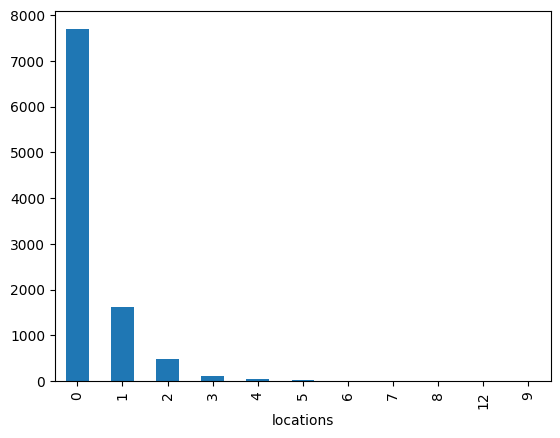

In [42]:
uk_geo_valid['locations'].apply(len).value_counts().plot.bar()

## Original models

In [44]:
from transformers import pipeline

In [46]:
model_uk = "../models/model-uk/checkpoint-14096"
classifier_uk = pipeline("token-classification", model=model_uk, aggregation_strategy="simple")

loading configuration file ../models/model-uk/checkpoint-14096/config.json
Model config BertConfig {
  "_name_or_path": "../models/model-uk/checkpoint-14096",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-LOC",
    "2": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 1,
    "I-LOC": 2,
    "O": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version

In [55]:
%%time
preds = classifier_uk(uk_geo_valid['text'].to_list()[:100], num_workers=6)

For ChunkPipeline using num_workers>0 is likely to result in errors since everything is iterable, setting `num_workers=1` to guarantee correctness.


CPU times: user 34.7 s, sys: 257 ms, total: 35 s
Wall time: 8.94 s


In [54]:
preds

[[{'entity_group': 'LOC',
   'score': 0.9998358,
   'word': 'Чернівецькій області',
   'start': 137,
   'end': 157}],
 [],
 [],
 [],
 [{'entity_group': 'LOC',
   'score': 0.9934742,
   'word': 'Туреччини',
   'start': 19,
   'end': 28},
  {'entity_group': 'LOC',
   'score': 0.99696445,
   'word': 'Сирії',
   'start': 49,
   'end': 54}],
 [],
 [],
 [],
 [],
 [{'entity_group': 'LOC',
   'score': 0.9984896,
   'word': 'Румунії',
   'start': 26,
   'end': 33}]]

## ONNX Conversion

## Quantization